# Building an MPS as a tree and using TEBD for time-evolution
A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [100]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

We want to analyse a chain of $N$-many qubits that evolves under a Heisenber Hamiltonian of the form
$$
H = -J \sum_{n=0}^{N-1} X_n X_{n+1} - g \sum_{n=0}^{N-1} Z_n.
$$

As a first step we will initalise a tree tensor network (TTN) representing an MPS in the initial state where all qubits are in the state $|0>$

## Setting up and running TEBD

In [101]:
num_sites = 5

zero_state = np.asarray([1, 0])

# This needs to become a 3-tensor with leg order (left_virt, physical, right_virt)
# Initially the virtual legs are trivial, i.e. of dimension 1
zero_state = zero_state.reshape((1,2,1))

# Now the TTN is created an initially empty
mps = ptn.TreeTensorNetwork()

# We have to add the sites one by one.
for site in range(num_sites):
    identifier = "site" + str(site)
    
    if site == 0:
        # Open boundary conditions on first site
        node = ptn.TensorNode(zero_state[0], identifier = identifier)
        
        mps.add_root(node)
        
    elif 0 < site:
        if site == num_sites - 1:
            # Open boundary conditions on last site
            node = ptn.TensorNode(zero_state[:,:,0], identifier = identifier)
        else:
            node = ptn.TensorNode(zero_state, identifier = identifier)
        
        parent_id = "site" + str(site - 1)
        
        if site == 1:
            # Due to boundary condition on first site
            mps.add_child_to_parent(node, 0, parent_id, 1)
        else:
            mps.add_child_to_parent(node, 0, parent_id, 2)

We find the TTN contains all the desired sites as nodes and is normalised:

In [102]:
node_shapes = {node_id: mps.nodes[node_id].tensor.shape for node_id in mps.nodes}
print(node_shapes)

print(f"Norm = {np.sqrt(ptn.scalar_product(mps))}")

{'site0': (2, 1), 'site1': (1, 2, 1), 'site2': (1, 2, 1), 'site3': (1, 2, 1), 'site4': (1, 2)}
Norm = 1.0


The next step is to set up the Hamiltonian under which the MPS time-evolves.

In [103]:
# Define constants
mJ = -1.5
mg = -0.5

# Define operators
X, _, Z = ptn.pauli_matrices()

gZ = mg * Z

hamiltonian = ptn.Hamiltonian()

# Add the two-site interaction
for site in range(0,num_sites-1): # There is no interaction of the form X_N*X_{N+1}
    term = {"site" + str(site): mJ * X, "site" + str(site +1): X}
    hamiltonian.add_term(term)
    
# Add local interactions
for site in range(0,num_sites):
    term = {"site" + str(site): gZ}
    hamiltonian.add_term(term)
    
print(hamiltonian)

[{'site0': array([[-0. , -1.5],
       [-1.5, -0. ]]), 'site1': array([[0, 1],
       [1, 0]])}, {'site1': array([[-0. , -1.5],
       [-1.5, -0. ]]), 'site2': array([[0, 1],
       [1, 0]])}, {'site2': array([[-0. , -1.5],
       [-1.5, -0. ]]), 'site3': array([[0, 1],
       [1, 0]])}, {'site3': array([[-0. , -1.5],
       [-1.5, -0. ]]), 'site4': array([[0, 1],
       [1, 0]])}, {'site0': array([[-0.5, -0. ],
       [-0. ,  0.5]])}, {'site1': array([[-0.5, -0. ],
       [-0. ,  0.5]])}, {'site2': array([[-0.5, -0. ],
       [-0. ,  0.5]])}, {'site3': array([[-0.5, -0. ],
       [-0. ,  0.5]])}, {'site4': array([[-0.5, -0. ],
       [-0. ,  0.5]])}]


Finally we can set up the TEBD simulation.

In [104]:
# Time parameters
time_step_size = 0.0001
final_time = 1

# Truncation parameters
max_bond_dim = 20
rel_tol = 0.0001

# Splitting, i.e. in which order do we want the terms of the Hamiltonian to be applied
# First the local terms
custom_splitting = [num_sites - 1 + ind for ind in range(0,num_sites)]
# The the two-site interaction
custom_splitting.extend([ind for ind in range(0,num_sites - 1)])

# We want to observe the evolution of the Z-operator expectation at each site.
operators = [{node_id: Z} for node_id in mps.nodes]

tebd_sim = ptn.TEBD(mps, hamiltonian, time_step_size=time_step_size, final_time=final_time,
                    custom_splitting=custom_splitting, operators=operators,
                    max_bond_dim=20, rel_tol=rel_tol )

# After the set up is complete, we merely have to run the simulation
tebd_sim.run()

## Running the reference matrix vector computation
As a reference we will run a computation on a full state vector. Thus we have to reinitialise the initial state:

In [105]:
zero_state = np.asarray([1,0])

ref_state = zero_state

for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)
    
print(f"Initial state {ref_state} is a vector with 2^{num_sites}={len(ref_state)} entries.")

Initial state [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] is a vector with 2^5=32 entries.


Furthermore we need to initialise the Hamiltonian as a matrix:

In [106]:
ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites))

I = np.eye(2)

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, gZ)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
print(f"The Hamiltonian is a {ref_hamiltonian.shape}-shaped matrix and contains (2^{num_sites})^2={len(ref_state)**2} entries.")

The Hamiltonian is a (32, 32)-shaped matrix and contains (2^5)^2=1024 entries.


We also have to compute the Hamiltonian's exponent. When using the `TEBD`-class this happened automatically internally.

In [107]:
exp_operator = expm(-1j*time_step_size*ref_hamiltonian)

As a final step of the set-up we have to define the operators from which we desire the expectation values.

In [108]:
operators = []

for sites in range(num_sites):
    site_operator = np.asarray([1])
    for sites2 in range(num_sites):
        if sites2 == sites:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
            
    operators.append(site_operator)

We can finally run the time-evolution.

In [109]:
num_time_steps = int(np.ceil(final_time / time_step_size))

results = np.zeros((len(operators) + 1, num_time_steps + 1), dtype=complex)

for time_step in range(num_time_steps + 1):
    if time_step != 0:
        ref_state = exp_operator @ ref_state
    
    conj_state = np.conjugate(ref_state.T)
    for i, operator in enumerate(operators):
        results[i,time_step] = conj_state @ operator @ ref_state
        
    results[-1,time_step] = time_step * time_step_size
    
results.shape

(6, 10001)

## Extracting results from TEBD
The expectation values and times are saved in the attribute `TEBD.results`:

In [110]:
times = [time.real for time in tebd_sim.results[-1]]

exp_val_Z_5 = [exp_val.real for exp_val in tebd_sim.results[0]]

The operators of which expectation values were calculated are hermitian, so their expectation values should be real numbers:

In [111]:
max([exp_val.imag for exp_val in tebd_sim.results[0]])

0.0

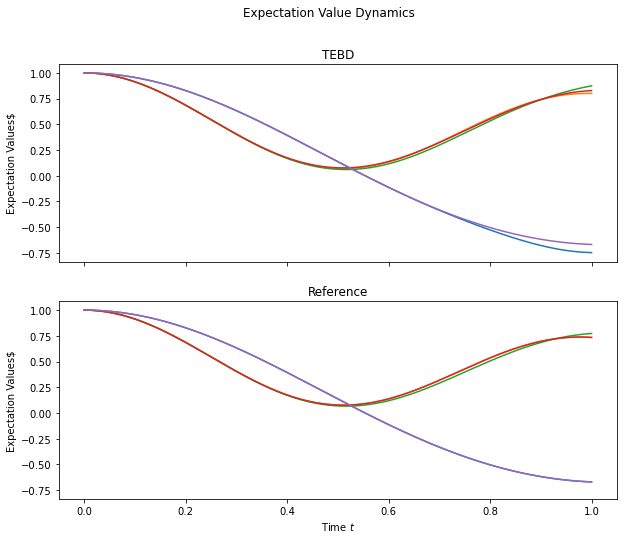

In [112]:
ref_times = [time.real for time in results[-1]]

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,8))

fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0].plot(times, [exp_val.real for exp_val in tebd_sim.results[site]])

axs[0].set_ylabel("Expectation Values$")
axs[0].set_title("TEBD")

for site in range(num_sites):
    axs[1].plot(ref_times, [exp_val.real for exp_val in results[site]])

axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Expectation Values$")
axs[1].set_title("Reference")

plt.show()

We can already see that both are very similar. Let us compare the actual errors:

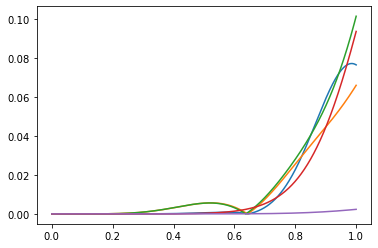

In [113]:
errors = results[0:-1] - tebd_sim.results[0:-1]

fig2 = plt.figure()

for error_row in errors:
    plt.plot(times, [abs(error) for error in error_row])

plt.show()